In [1]:
%matplotlib inline
import h2o
import xgboost
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import statsmodels.api as sm
import matplotlib.pylab as plt
from sklearn.svm import SVC
from sklearn.metrics import *
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

from h2o.estimators.random_forest import H2ORandomForestEstimator
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 50)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Function

In [2]:
def str_to_num(df, train=True, activity_id = True):
    '''
    ppl_id : del string and change dtype to num
    activity id : del number and str(act)
    type : del string and change dtype to num
    bool : 0, 1
    inplace : True
    
    parameta
    --------
    df : DataFrame 
    train : bool
        train :True, test : False
    --------
    '''
    col_list = list(df)
    col_list.remove('date_x')
    col_list.remove('date_y')
    if train:
        col_list.remove('outcome')
        
    for col in col_list[:col_list.index('char_9_y')+1]:
        if col == 'activity_id':
            if activity_id == True:
                df.loc[:,col] = df.loc[:,col].apply(lambda x: x.split('_')[0])
                df.replace('act', '', regex=True, inplace = True)
        elif col == 'people_id':
            df.loc[:,col] = df.loc[:,col].apply(lambda x: x.split('_')[1])
        else :
            df.loc[:,col][df.loc[:,col].isnull()==False] = df.loc[:,col][df.loc[:,col].isnull()==False].apply(lambda x: x.split(' ')[1])
        df.loc[:, col] = pd.to_numeric(df.loc[:, col][df.loc[:,col].isnull()==False]).astype(int)
            
    for col in col_list[col_list.index('char_10_y'):col_list.index('char_38')+1]:
        df.loc[:,col] = df.loc[:,col].replace({True:1, False:0})
        
    return df

In [3]:
def date_modify(df):
    '''
    add week_x, week_y, and Past_days
    inplace : True
    
    parameta
    --------
    df : DataFrame 
    --------
    '''
    df.insert(loc=list(df).index('date_x')+1 ,column='week_x', value=df['date_x'].dt.weekday)
    df.insert(loc=list(df).index('date_y')+1 ,column='week_y', value=df['date_y'].dt.weekday)
    df.insert(loc=list(df).index('week_x')+1 ,column='Past_days', value=(df.date_x - df.date_y).astype('timedelta64[D]'))
    df['days']=(pd.to_numeric(df.date_x)//86400000000000) - (pd.to_numeric(df.date_x)//86400000000000).min()
    return df

In [4]:
def add_bool_sum(df):
    '''
    add colum 'bool_sum' : sum of char_10_y ~ char_37
    inplace : False
    
    parameta
    --------
    df : DataFrame 
    --------
    '''
    temp = df.copy()
    temp['bool_sum'] = temp.iloc[:,list(temp).index('char_10_y'):list(temp).index('char_37')].sum(axis=1)
    return temp

In [5]:
def num_to_cat(df, columns):
    '''
    change dtype(num to str)
    inplace : False
    
    parameta
    --------
    df : DataFrame 
    columns : list
    --------
    '''
    temp = df.copy()
    temp.loc[:,columns] = pd.DataFrame(temp.loc[:,columns], dtype='str')
    return temp

In [6]:
def one_hot_encoder(df, columns):
    '''
    columns encoding(one-hot-encoding)
    inplace : False
    
    parameta
    --------
    df : DataFrame 
    columns : list
    --------
    '''
    temp = df.copy()
    for col in columns:
        for i in list(pd.get_dummies(temp[col]))[-1::-1]:    
            temp.insert(loc=list(temp).index(col)+1 ,column=col+str(i), value=pd.get_dummies(temp.loc[:,col]).loc[:,i])
        temp = temp.drop([col], axis=1)
    return temp

In [7]:
import io
import pydot
from IPython.core.display import Image 
from sklearn.tree import export_graphviz

# 강사님 함수
def draw_decision_tree(model, feature_names):
    dot_buf = io.StringIO() 
    export_graphviz(model, out_file=dot_buf, feature_names=feature_names)
    graph = pydot.graph_from_dot_data(dot_buf.getvalue())[0] 
    image = graph.create_png()
    return Image(image)

# data load & 전처리

### train data

In [8]:
df_train = pd.read_csv('./data/act_train.csv', parse_dates=['date'])
df_people = pd.read_csv('./data/people.csv', parse_dates=['date'])
df_merge = pd.merge(df_train, df_people, on='people_id')

In [9]:
str_to_num(df_merge, train=True)
date_modify(df_merge)
df_merge = add_bool_sum(df_merge)
del df_train

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### test data

In [10]:
df_test = pd.read_csv('./data/act_test.csv', parse_dates=['date'])
df_merge_test = pd.merge(df_test, df_people, how='inner', on='people_id')

In [11]:
# submissin 만들때 필요함
df_test_act_id = df_merge_test.activity_id.copy()

In [12]:
str_to_num(df_merge_test, train=False)
date_modify(df_merge_test)
df_merge_test = add_bool_sum(df_merge_test)
del df_test, df_people

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


#### save data

In [ ]:
# df_merge.to_csv("train_merge.csv")
# df_merge_test.to_csv("test_merge.csv")

In [ ]:
# df_merge = pd.read_csv('./train_merge.csv', parse_dates=['date_x', 'date_y'])
# df_merge_test = pd.read_csv('./test_merge.csv', parse_dates=['date_x', 'date_y'])

# group & date

In [ ]:
df_gd = df_merge.loc[:, ['group_1', 'days', 'outcome']].copy()

In [ ]:
df_gd_test = pd.DataFrame({'activity_id' : df_test_act_id, 'group_1' : df_merge_test.group_1, 'days' : df_merge_test['days']})

In [ ]:
%%time
gp_0 = []
gp_1 = []
gp_01= []
for gp in df_gd.group_1.unique():
    if len(df_gd[df_gd.group_1==gp].loc[:,'outcome'].unique()) == 1:
        if df_gd[df_gd.group_1==gp].loc[:,'outcome'].iloc[0]:
            gp_1.append(gp)
        else:
            gp_0.append(gp)
    else :
        gp_01.append(gp)

In [ ]:
%%time
gp_0_test = []
gp_1_test = []
gp_01_test= []
gp_nan_test = []
for col in df_gd_test.group_1.unique():
    if col in gp_0:
        gp_0_test.append(col)
    elif col in gp_1:
        gp_1_test.append(col)
    elif col in gp_01:
        gp_01_test.append(col)
    else :
        gp_nan_test.append(col)

In [ ]:
len(gp_0), len(gp_1), len(gp_01)

In [ ]:
len(gp_0_test), len(gp_1_test), len(gp_01_test), len(gp_nan_test)

In [ ]:
%%time
gp_dict = dict()
for gp in gp_01_test:
    gp_dict[gp] = []
    a = df_gd[df_gd.group_1==gp].loc[:,['days','outcome']].sort_values(by=['days'])
    for i in range(len(df_gd[df_gd.group_1==gp])-1):
        if a.iloc[i].outcome - a.iloc[i+1].outcome == 1:
            gp_dict[gp].append(a.iloc[i].days)
        elif a.iloc[i].outcome - a.iloc[i+1].outcome == -1:
            gp_dict[gp].append(-a.iloc[i].days)
        else:
            pass

In [ ]:
plt.figure(figsize=(25,3))
plt.scatter(df_gd[df_gd.loc[:,'group_1']==gp_01[0]]['days'], df_gd[df_gd.loc[:,'group_1']==gp_01[0]].outcome, alpha = 0.25) 
plt.ylim(-0.1,1.1)
plt.show()

# EDA

In [ ]:
for d in ['date_x', 'date_y']:
    print('Start of ' + d + ': ' + str(df_merge[d].min().date()))
    print('  End of ' + d + ': ' + str(df_merge[d].max().date()))
    print('Range of ' + d + ': ' + str(df_merge[d].max() - df_merge[d].min()) + '\n')

In [ ]:
df_merge.describe()

In [ ]:
df_merge[['date_x', 'date_y']].describe()

In [ ]:
pd.DataFrame(df_merge.people_id, dtype='object').describe()

In [ ]:
df_merge.people_id.unique()

In [ ]:
# ppl 별 구매 경향
plt.figure(figsize=(20,30))
for i, ppl in enumerate(df_merge.people_id.unique()[:20]):
    plt.subplot(10,2,i+1)    
    plt.scatter(df_merge[df_merge.people_id == ppl]['Past_days'], \
                df_merge[df_merge.people_id == ppl].outcome, alpha = 0.25) 
    plt.ylim(-0.1,1.1)
plt.show()

In [ ]:
df_merge.people_id.value_counts().head()

In [ ]:
# ppl 별 구매 경향 top 5
plt.figure(figsize=(20,10))
for i, ppl in enumerate([294918, 370270, 105739, 54699, 64887]):
    plt.subplot(5,1,i+1)    
    plt.scatter(df_merge[df_merge.people_id == ppl]['Past_days'], \
                df_merge[df_merge.people_id == ppl].outcome, alpha = 0.25) 
    plt.ylim(-0.1,1.1)
plt.show()

In [ ]:
# group 별 구매 경향
plt.figure(figsize=(20,30))
for i, group in enumerate(df_merge.group_1.unique()[:20]):
    plt.subplot(10,2,i+1)    
    plt.scatter(df_merge[df_merge.group_1 == group]['Past_days'], \
                df_merge[df_merge.group_1 == group].outcome, alpha = 0.25) 
    plt.ylim(-0.1,1.1)
plt.show()

In [ ]:
# group 별 구매 경향 top 5

plt.figure(figsize=(20,10))
for i, group in enumerate([17304, 667, 8386, 9280,450]):
    plt.subplot(5,1,i+1)    
    plt.scatter(df_merge[df_merge.group_1 == group]['Past_days'], \
                df_merge[df_merge.group_1 == group].outcome, alpha = 0.25) 
    plt.ylim(-0.1,1.1)
plt.show()

In [ ]:
sns.factorplot(x="week_x", y="outcome", row="activity_category", data=df_merge,
               size=2, aspect=3, kind="point")
plt.show()

In [ ]:
sns.factorplot(x="activity_category", y="outcome", row="week_x", data=df_merge,
               size=2, aspect=3, kind="point")
plt.show()

#### sample

In [ ]:
df_sample = df_merge.sample(frac = 0.1, random_state=0).copy()
df_sample = add_bool_sum(df_sample)

In [ ]:
df_sample2 = df_merge.sample(frac = 0.1, random_state=1).copy()
df_sample2 = add_bool_sum(df_sample2)

In [ ]:
df_sample.groupby(['activity_id', 'activity_category']).count()

In [ ]:
plt.figure(figsize=(20,4))
sns.kdeplot(df_sample[df_sample.outcome==0]['Past_days'])
sns.kdeplot(df_sample[df_sample.outcome==1]['Past_days'])
plt.show()

In [ ]:
plt.figure(figsize=(20,4))
sns.kdeplot(df_sample[df_sample.outcome==0]['week_x'])
sns.kdeplot(df_sample[df_sample.outcome==1]['week_x'])
plt.show()

#### char_1_x ~ char_9_x

In [ ]:
plt.figure(figsize=(20,12))
for i, feat in enumerate(df_sample.columns[list(df_sample).index('char_1_x'):list(df_sample).index('char_9_x')+1]):
    plt.subplot(3,3,i+1)
    sns.countplot(feat, hue='outcome', data=df_sample)
plt.show()

#### char_2_y ~ char_9_y

In [ ]:
sns.countplot('char_2_y', hue='outcome', data=df_sample)
plt.show

In [ ]:
plt.figure(figsize=(20,12))
for i, feat in enumerate(df_sample.columns[list(df_sample).index('char_3_y'):list(df_sample).index('char_9_y')+1]):
    plt.subplot(3,3,i+1)
    sns.countplot(feat, hue='outcome', data=df_sample)
plt.show()

#### char_10_y ~ char_37

In [ ]:
plt.figure(figsize=(20,30))
for i, feat in enumerate(df_sample.columns[list(df_sample).index('char_10_y'):list(df_sample).index('char_37')+1]):
    plt.subplot(7,4,i+1)
    sns.countplot(feat, hue='outcome', data=df_sample)
plt.show()

In [ ]:
plt.figure(figsize=(20,5))
sns.countplot('bool_sum', hue='outcome', data=df_sample)
plt.show()

#### char_38

In [ ]:
facet = sns.FacetGrid(df_sample, hue='outcome', aspect=4)
facet.map(sns.kdeplot, 'char_38', shade=True)
facet.set(xlim=(0, df_sample['char_38'].max()))
facet.add_legend()

plt.show()

In [ ]:
sns.boxplot(x="outcome", y="char_38", data=df_sample)
plt.show()

In [ ]:
del df_sample, df_sample2

# feature selection

In [ ]:
model1 = sm.OLS.from_formula("outcome ~ char_10_y + char_11 + char_12 + char_13 + char_14 + char_15 + char_16 + char_17 + char_18 + \
                            char_19 + char_20 + char_21 + char_22 + char_23 + char_24 + char_25 + char_26 + char_27 + char_28 + \
                            char_29 + char_30 + char_31 + char_32 + char_33 + char_34 + char_35 + char_36 + char_37", data=df_merge)
model2 = sm.OLS.from_formula("outcome ~ bool_sum", data=df_merge)
model3 = sm.OLS.from_formula("outcome ~ char_10_y + char_11 + char_12 + char_13 + char_14 + char_15 + char_16 + char_17 + char_18 + \
                            char_19 + char_20 + char_21 + char_22 + char_23 + char_24 + char_25 + char_26 + char_27 + char_28 + char_29 + \
                            char_30 + char_31 + char_32 + char_33 + char_34 + char_35 + char_36 + char_37 + bool_sum", data=df_merge)
result1 = model1.fit()
result2 = model2.fit()
result3 = model3.fit()

sm.stats.anova_lm(result1, result2, result3)

In [ ]:
sm.stats.anova_lm(result1)

In [ ]:
sm.stats.anova_lm(result2)

In [ ]:
sm.stats.anova_lm(result3)

# modeling

#### fillna(0)

In [13]:
df_merge.fillna(0, inplace=True)
df_merge_test.fillna(0, inplace=True)

#### columns

In [17]:
a = list(df_merge)
a.remove('date_x')
a.remove('date_y')
a.remove('bool_sum')
a.remove('people_id')
a.remove('activity_id')
a.remove('week_x')
a.remove('week_y')
a.remove('days')
a.remove('group_1')
a.remove('outcome')
print(a)

['Past_days', 'activity_category', 'char_1_x', 'char_2_x', 'char_3_x', 'char_4_x', 'char_5_x', 'char_6_x', 'char_7_x', 'char_8_x', 'char_9_x', 'char_10_x', 'char_1_y', 'char_2_y', 'char_3_y', 'char_4_y', 'char_5_y', 'char_6_y', 'char_7_y', 'char_8_y', 'char_9_y', 'char_10_y', 'char_11', 'char_12', 'char_13', 'char_14', 'char_15', 'char_16', 'char_17', 'char_18', 'char_19', 'char_20', 'char_21', 'char_22', 'char_23', 'char_24', 'char_25', 'char_26', 'char_27', 'char_28', 'char_29', 'char_30', 'char_31', 'char_32', 'char_33', 'char_34', 'char_35', 'char_36', 'char_37', 'char_38']


## 로지스틱 회귀분석

In [ ]:
logit_mod = sm.Logit.from_formula("outcome ~ Past_days + char_38 + bool_sum", data=df_merge)
logit_res = logit_mod.fit(disp=0)
print(logit_res.summary())

## 나이브 베이즈

+ 베르누이 분포 나이브 베이즈 모형

In [ ]:
# clf_bern = BernoulliNB().fit(X, y)

In [ ]:
# print(classification_report(df_sample2.outcome, clf_bern.predict(df_sample2[df_sample2.columns[-30:-2]])))

+ 가우시안 정규 분포 나이브 베이즈 모형

In [ ]:
clf_norm = GaussianNB().fit(df_merge[a], df_merge.outcome)

In [ ]:
cross_val_score(clf_norm, df_merge[a], df_merge.outcome, scoring="roc_auc", cv=10).mean()

## 의사 결정 나무

In [18]:
tree = DecisionTreeClassifier(criterion='entropy', max_depth=10).fit(df_merge[a], df_merge.outcome)

In [19]:
cross_val_score(tree, df_merge[a], df_merge.outcome, scoring="roc_auc", cv=10).mean()

0.91260771771241966

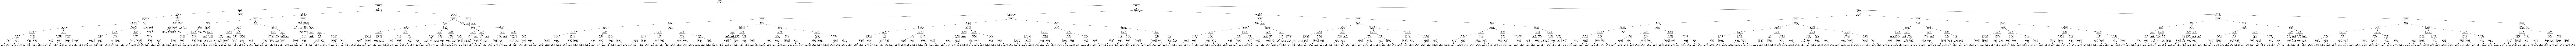

In [20]:
draw_decision_tree(tree, a)

In [ ]:
# df_submission = pd.DataFrame({'activity_id' : df_test_act_id, 'outcome' : tree2.predict(df_merge_test[a])}).set_index('activity_id')
# df_submission.to_csv("df_submission_tree.csv")

## 랜덤 포레스트

+ RandomForestClassifier

In [21]:
rfc = RandomForestClassifier(n_estimators=30, max_depth=10).fit(df_merge[a], df_merge.outcome)

In [22]:
cross_val_score(rfc, df_merge[a], df_merge.outcome, scoring="roc_auc", cv=10).mean()

0.91433908361494609

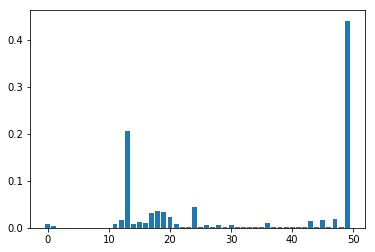

In [28]:
importance = rfc.feature_importances_
importance = pd.DataFrame(importance, index=df_merge.loc[:,a].columns, 
                          columns=["Importance"])

importance["Std"] = np.std([tree.feature_importances_ for tree in rfc.estimators_], axis=0)

x = range(importance.shape[0])
y = importance.iloc[:, 0]
yerr = importance.iloc[:, 1]

plt.bar(x, y)

plt.show()

In [32]:
importance.sort_values(by='Importance', ascending=False)

,Importance,Std
char_38,0.440376,0.264181
char_2_y,0.205419,0.190749
char_13,0.044045,0.077466
char_7_y,0.035065,0.014974
char_8_y,0.034574,0.058582
char_6_y,0.031002,0.018202
char_9_y,0.023412,0.032216
char_36,0.017669,0.046013
char_34,0.016905,0.044469
char_1_y,0.016345,0.021427


In [ ]:
# # rfc = RandomForestClassifier(n_estimators=30).fit(df_merge[a], df_merge.outcome) 0.88
# df_submission = pd.DataFrame({'activity_id' : df_test_act_id, 'outcome' : rfc.predict(df_merge_test[a])}).set_index('activity_id')
# df_submission.to_csv("df_submission_rfc.csv")

In [ ]:
# df_submission = pd.DataFrame({'activity_id' : df_test_act_id, 'outcome' : rfc2.predict(df_merge_test[b])}).set_index('activity_id')
# df_submission.to_csv("df_submission_rfc_b.csv")

+ ExtraTreesClassifier

In [23]:
%%time
efc = ExtraTreesClassifier(n_estimators=30, max_depth=10).fit(df_merge[a], df_merge.outcome)

Wall time: 1min 11s


In [24]:
%%time
cross_val_score(efc, df_merge[a], df_merge.outcome, scoring="roc_auc", cv=10).mean()

Wall time: 11min 4s


0.91426938786331946

In [ ]:
# df_submission = pd.DataFrame({'activity_id' : df_test_act_id, 'outcome' : efc.predict(df_merge_test[a])}).set_index('activity_id')
# df_submission.to_csv("df_submission_efc.csv")

In [ ]:
# df_submission = pd.DataFrame({'activity_id' : df_test_act_id, 'outcome' : efc2.predict(df_merge_test[b])}).set_index('activity_id')
# df_submission.to_csv("df_submission_efc_b.csv")

# xgboost

In [25]:
df_merge2 = one_hot_encoder(df_merge, ['activity_id', 'activity_category'])

In [26]:
df_merge_test2 = one_hot_encoder(df_merge_test, ['activity_id', 'activity_category'])

In [36]:
df_merge_test2

,people_id,activity_id1,activity_id2,date_x,week_x,Past_days,activity_category1,activity_category2,activity_category3,activity_category4,activity_category5,activity_category6,activity_category7,char_1_x,char_2_x,char_3_x,char_4_x,char_5_x,char_6_x,char_7_x,char_8_x,char_9_x,char_10_x,char_1_y,group_1,char_2_y,date_y,week_y,char_3_y,char_4_y,char_5_y,char_6_y,char_7_y,char_8_y,char_9_y,char_10_y,char_11,char_12,char_13,char_14,char_15,char_16,char_17,char_18,char_19,char_20,char_21,char_22,char_23,char_24,char_25,char_26,char_27,char_28,char_29,char_30,char_31,char_32,char_33,char_34,char_35,char_36,char_37,char_38,days,bool_sum
0,100004,1,0,2022-07-20,2,0.0,1,0,0,0,0,0,0,5.0,10.0,5.0,1.0,6.0,1.0,1.0,7.0,4.0,0.0,2,22593,3,2022-07-20,2,40,25,9,4,16,2,2,1,1,1,1,1,0,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,76,3,25
1,100004,0,1,2022-07-20,2,0.0,0,0,0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,682.0,2,22593,3,2022-07-20,2,40,25,9,4,16,2,2,1,1,1,1,1,0,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,76,3,25
2,10001,1,0,2022-10-14,4,0.0,1,0,0,0,0,0,0,12.0,1.0,5.0,4.0,6.0,1.0,1.0,13.0,10.0,0.0,2,25417,3,2022-10-14,4,6,6,4,1,1,2,2,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,90,89,25
3,10001,1,0,2022-11-27,6,44.0,1,0,0,0,0,0,0,20.0,10.0,5.0,4.0,6.0,1.0,1.0,5.0,5.0,0.0,2,25417,3,2022-10-14,4,6,6,4,1,1,2,2,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,90,133,25
4,10001,0,1,2022-10-15,5,1.0,0,0,0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3015.0,2,25417,3,2022-10-14,4,6,6,4,1,1,2,2,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,90,90,25
5,10001,0,1,2022-11-27,6,44.0,0,0,0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4987.0,2,25417,3,2022-10-14,4,6,6,4,1,1,2,2,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,90,133,25
6,10001,0,1,2022-10-15,5,1.0,0,0,0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3015.0,2,25417,3,2022-10-14,4,6,6,4,1,1,2,2,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,90,90,25
7,10001,0,1,2022-10-15,5,1.0,0,0,0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3015.0,2,25417,3,2022-10-14,4,6,6,4,1,1,2,2,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,90,90,25
8,10001,0,1,2022-10-15,5,1.0,0,0,0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3015.0,2,25417,3,2022-10-14,4,6,6,4,1,1,2,2,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,90,90,25
9,10001,0,1,2022-11-28,0,45.0,0,0,0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3015.0,2,25417,3,2022-10-14,4,6,6,4,1,1,2,2,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,90,134,25


In [33]:
a2 = list(df_merge2)
a2.remove('date_x')
a2.remove('date_y')
a2.remove('bool_sum')
a2.remove('people_id')
a2.remove('week_x')
a2.remove('week_y')
a2.remove('days')
a2.remove('group_1')
a2.remove('outcome')
print(a2)

['activity_id1', 'activity_id2', 'Past_days', 'activity_category1', 'activity_category2', 'activity_category3', 'activity_category4', 'activity_category5', 'activity_category6', 'activity_category7', 'char_1_x', 'char_2_x', 'char_3_x', 'char_4_x', 'char_5_x', 'char_6_x', 'char_7_x', 'char_8_x', 'char_9_x', 'char_10_x', 'char_1_y', 'char_2_y', 'char_3_y', 'char_4_y', 'char_5_y', 'char_6_y', 'char_7_y', 'char_8_y', 'char_9_y', 'char_10_y', 'char_11', 'char_12', 'char_13', 'char_14', 'char_15', 'char_16', 'char_17', 'char_18', 'char_19', 'char_20', 'char_21', 'char_22', 'char_23', 'char_24', 'char_25', 'char_26', 'char_27', 'char_28', 'char_29', 'char_30', 'char_31', 'char_32', 'char_33', 'char_34', 'char_35', 'char_36', 'char_37', 'char_38']


In [35]:
%%time
xgb = xgboost.XGBClassifier(n_estimators=30, max_depth=10).fit(df_merge2[a2], df_merge2.outcome)

Wall time: 5min 51s


In [ ]:
%%time
cross_val_score(xgb, df_merge[a2], df_merge.outcome, scoring="roc_auc", cv=10).mean()

In [ ]:
# df_submission = pd.DataFrame({'activity_id' : df_test_act_id, 'outcome' : xgb.predict(df_merge_test2[a2])}).set_index('activity_id')
# df_submission.to_csv("df_submission_xgb2.csv")

In [ ]:
# df_submission = pd.DataFrame({'activity_id' : df_test_act_id, 'outcome' : xgb2.predict(df_merge_test[b])}).set_index('activity_id')

# df_submission.to_csv("df_submission_xgb_b.csv")

# 퍼셉트론

# 서포트 벡터 머신

In [ ]:
SVC_model = SVC(kernel='linear').fit(df_merge[a], df_merge.outcome)

# voting

In [37]:
df_submission = pd.DataFrame({'activity_id' : df_test_act_id, 
                              'outcome1' : tree.predict(df_merge_test[a]),
                              'outcome2' : rfc.predict(df_merge_test[a]),
                              'outcome3' : efc.predict(df_merge_test[a]),
                              'outcome4' : xgb.predict(df_merge_test2[a2]),
                             }).set_index('activity_id')
# df_submission.to_csv("df_submission_xgb2.csv")

In [39]:
df_submission['outcome'] = df_submission.outcome1 + df_submission.outcome2 + df_submission.outcome3 + df_submission.outcome4

# H2O

In [ ]:
date_modify(df_merge1)
df_merge1 = add_bool_sum(df_merge1)

In [ ]:
df_h2o = df_merge1.sample(frac = 0.1, random_state=0).copy()

In [ ]:
h2o.init()

In [ ]:
coltype_dict = dict()
ignore_list = ['people_id', 'activity_id', 'group_1']
numeric_list = ['char_38', 'bool_sum']
date_list = ['date_x', 'date_y']
for col in list(df_merge1):
    type_ = 'string'
    if col in ignore_list:
        type_ = 'string'
    elif col in numeric_list:
        type_ = 'numeric'
    elif col in date_list:
        type_ = 'time'
    else:
        type_ = 'enum'
    coltype_dict[col] = type_
print(coltype_dict)
print()

na_dict = dict()
na_list = ['char_{}_x'.format(x) for x in range(1, 11)]
for item in na_list:
    na_dict[item] = ['0']
print(na_dict)

del ignore_list, numeric_list, date_list

In [ ]:
%%time
hf_merge1 = h2o.H2OFrame(df_merge1, column_types=coltype_dict, na_strings=na_dict)

In [ ]:
train, valid, test = covtype_df.split_frame([0.6, 0.2], seed=1234)

#Prepare predictors and response columns
covtype_X = covtype_df.col_names[:-1]     #last column is Cover_Type, our desired response variable 
covtype_y = covtype_df.col_names[-1]    

In [ ]:
rf_v1 = H2ORandomForestEstimator(
    model_id="rf_covType_v1",
    ntrees=200,
    stopping_rounds=2,
    score_each_iteration=True,
    seed=1000000)

In [ ]:
rf_v1.train(covtype_X, covtype_y, training_frame=train, validation_frame=valid)